In [1]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.8 MB/s eta 0:00:00


In [2]:
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np

Found encoding: Sanger Phred+33


/usr/local/lib/python3.10/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


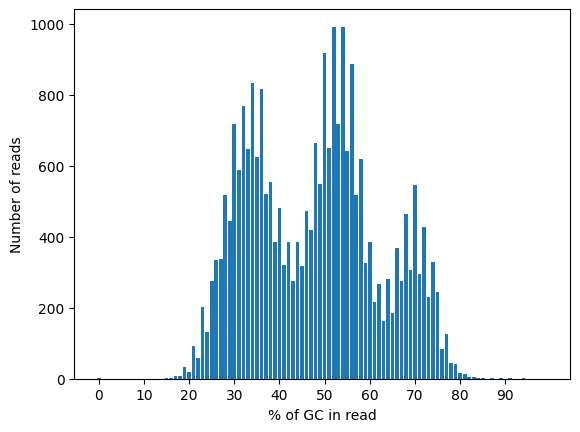

****Alignment****
sequence: gi|2604885558|emb|OY754442.1| Escherichia coli isolate S142 genome assembly, chromosome: 1
length: 4663521
e value: 5.5435e-70
CGGACGCGCACCTGTGGCGTAGAACTGAATCTCATCACGAACAGCGCCGCCTAAAAGTTTATAAACCGGAAGCCC...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||...
CGGACGCGCACCTGTGGCGTAGAACTGAATCTCATCACGAACAGCGCCGCCTAAAAGTTTATAAACCGGAAGCCC...
****Alignment****
sequence: gi|2604885558|emb|OY754442.1| Escherichia coli isolate S142 genome assembly, chromosome: 1
length: 4663521
e value: 1.93487e-69
GAACATCCAGCTCGCGCTCCGTCAGCACGCTGAAGGGATCTTCTTCCGCGCCAAACATTTCACGTTCACGTAAGT...
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||...
GAACATCCAGCTCGCGCTCCGTCAGCACGCTGAAGGGATCTTCTTCCGCGCCAAACATTTCACGTTCACGTAAGT...
****Alignment****
sequence: gi|2604885558|emb|OY754442.1| Escherichia coli isolate S142 genome assembly, chromosome: 1
length: 4663521
e value: 6.75337e-69
CCCATTGTTGATGAAGGCAGTAACGCCGCTTTTGACATCGTTTATAGCGATGCGCAAGG

In [3]:
class BioQualityAnalyzer:
    _input_file = ''
    _sequences_with_gc_percentages = []
    _read_numbers_by_GC_percentage = []
    _ranges_with_their_most_reads_no = []
    _peak_ranges = []
    _peak_sequences = []

    def __init__(self, input_read_file):
        self._input_file = input_read_file

# Funcija, kuri suranda nuskaitymu minimalia ir maksimalia reiksmes
    def _get_min_max_scores_of_reads(self):
        with open(self._input_file) as input_data:
            max_detected_value = -9999
            min_detected_value = 9999
            for title, seq, qual in FastqGeneralIterator(input_data):
                ascii_integers_of_read = [ord(score) for score in qual]
                if min(ascii_integers_of_read) < min_detected_value:
                    min_detected_value = min(ascii_integers_of_read)
                if max(ascii_integers_of_read) > max_detected_value:
                    max_detected_value = max(ascii_integers_of_read)
        return (min_detected_value, max_detected_value)

# Funkcija, kuri nustato artimiausia kodavima is duotuju
    def indentify_quality_encoding(self):
        ENCODINGS = {
            "Sanger Phred+33": (33, 0, 40),  # tipiskai (0, 40)
            "Solexa Solexa+64": (64, -5, 40),  # tipiskai (-5, 40)
            "Illumina 1.3+ Phred+64": (64, 0, 40), # tipiskai (0, 40)
            "Illumina 1.5+ Phred+64": (64, 3, 40), # tipiskai (3, 40) - 0,1 nenaudojami it 2 - 'B' - kokybes kontroles indikatorius
            "Illumina 1.8+ Phred+33": (33, 0, 41) # tipiskai (0, 41)
        }

        min_max_of_reads = self._get_min_max_scores_of_reads()
        min_val = min_max_of_reads[0]
        max_val = min_max_of_reads[1]
        diff_sums_dict = {}

        for encoding in ENCODINGS:
            diff_from_expected_min = abs(
                min_val - ENCODINGS[encoding][0] - ENCODINGS[encoding][1])
            diff_from_expected_max = abs(
                max_val - ENCODINGS[encoding][0] - ENCODINGS[encoding][2])
            diff_sum = diff_from_expected_min + diff_from_expected_max
            diff_sums_dict[encoding] = diff_sum

        smallest_diff_value_encoding = min(
            diff_sums_dict, key=diff_sums_dict.get)

        print("Found encoding: %s" % smallest_diff_value_encoding)

# Funkcija, kuri suskaiciuoja C/G procentalia dali nuskaitymuose
    def _find_gc_percentages_in_reads(self):
        with open(self._input_file) as in_data:
            counter = 1
            for title, seq, qual in FastqGeneralIterator(in_data):
                self._sequences_with_gc_percentages.append({'read_id': counter, 'title': title, 'sequence': seq, 'gc_perc': GC(seq), 'gc_perc_rounded': round(GC(seq))})
                counter += 1

# Funkcija, kuri suskaiciuoja nuskaitymu skaicius atitinkamiems procentams
    def _find_read_numbers_according_percentages(self):
        for i in range(0, 100):
            counter = 0
            for seq_GC_info in self._sequences_with_gc_percentages:
                if seq_GC_info['gc_perc_rounded'] == i:
                    counter += 1
            self._read_numbers_by_GC_percentage.append({'percentage_of_GC': i, 'reads_number': counter})

# Funkcija, kuri sudaro grafika
    def plot_gc_in_reads(self):
        self._find_gc_percentages_in_reads()
        self._find_read_numbers_according_percentages()
        y_pos = np.arange(len(range(0, 100)))

        plt.bar(y_pos, [x['reads_number'] for x in self._read_numbers_by_GC_percentage])

        percentages_to_plot = [percentage for percentage in range(0, 100) if percentage % 10 == 0]
        plt.xticks(percentages_to_plot)
        plt.xlabel("% of GC in read")
        plt.ylabel("Number of reads")

        plt.show()

# Funkcija, kuri sudaro piku grupes
    def get_peak_groups(self, range):
        iterator = 0
        ranges = []
        while iterator < 100:
            prev = iterator
            curr = prev + range
            group = [x['reads_number'] for x in self._read_numbers_by_GC_percentage if x['percentage_of_GC'] <= curr and x['percentage_of_GC'] > prev]
            ranges.append((prev, curr, sum(group)))
            iterator += range

        ranges.sort(key=lambda tup: tup[2], reverse=True)


        filtered_ranges = ranges[0:3]

        for range in filtered_ranges:
            self._peak_ranges.append((range[0], range[1]))

        self._find_percentage_of_GC_that_most_reads_in_peak_have()

    def _find_percentage_of_GC_that_most_reads_in_peak_have(self):
        ranges_with_their_most_reads_no = []
        for range in self._peak_ranges:
            max_reads = 0
            percentage_no = -1
            for read_number in self._read_numbers_by_GC_percentage:
                if read_number['percentage_of_GC'] >= range[0] and read_number['percentage_of_GC'] <= range[1] and read_number['reads_number'] > max_reads:
                    max_reads = read_number['reads_number']
                    percentage_no = read_number['percentage_of_GC']
            ranges_with_their_most_reads_no.append((range[0], range[1], percentage_no, max_reads))
        self._ranges_with_their_most_reads_no = ranges_with_their_most_reads_no

# Funkcija, surandanti sekas, kurios yra pikuose
    def find_peak_sequences(self):
        for range_with_its_most_reads in self._ranges_with_their_most_reads_no:
            sequences_in_range = []
            for sequence in self._sequences_with_gc_percentages:
                if len(sequences_in_range) >= 5:
                    break
                if (sequence['gc_perc_rounded'] == range_with_its_most_reads[2]):
                    sequences_in_range.append(sequence)

            self._peak_sequences.append({'range-min': range_with_its_most_reads[0], 'range_max': range_with_its_most_reads[1], 'sequences': [x for x in sequences_in_range]})
            sequences_in_range.clear()

#Funkcija, kuri atlieka BLAST paieska
    def do_blast_search(self):
        with open('bacteria.txt', 'w') as f:
            f.write(
                'Read_id\tRead_title\tRead sequence\tBLAST match sequence\tBacteria\tE_value\n')
            found_records = []
            all_sequences = []
            for peak in self._peak_sequences:
                sequences = [x for x in peak['sequences']]
                all_sequences += sequences
                result_handler = NCBIWWW.qblast(
                    program="blastn",
                    database="nt",
                    sequence=[x['sequence'] for x in sequences],
                    expect=10,
                    word_size=11,
                    nucl_reward=2,
                    hitlist_size=1,
                    nucl_penalty=-3,
                    gapcosts="5 2",
                    entrez_query='Bacteria [Organism]')

                blast_records = NCBIXML.parse(result_handler)
                for blast_record in blast_records:
                    for alignment in blast_record.alignments:
                        for hsp in alignment.hsps:
                            print("****Alignment****")
                            print("sequence:", alignment.title)
                            print("length:", alignment.length)
                            print("e value:", hsp.expect)
                            print(hsp.query[0:75] + "...")
                            print(hsp.match[0:75] + "...")
                            print(hsp.sbjct[0:75] + "...")

                            found_records.append({'sequence_name': alignment.title, 'e_value': hsp.expect, 'query': hsp.query, 'sbjct': hsp.sbjct})

            for found_record in found_records:
                found = False
                for seq in all_sequences:
                    if found_record['query'] in seq['sequence'] or seq['sequence'] in found_record['query']:
                        found = True
                        found_record['read_id'] = seq['read_id']
                        found_record['original_seq'] = seq['sequence']
                        found_record['title'] = seq['title']
                        break
                if found == False:
                    found_record['read_id'] = -1
                    found_record['original_seq'] = ''
                    found_record['title'] = 'title'

            for found_record in found_records:
                f.write('%d\t%s\t%s\t%s\t%s\t%d\n' % (found_record['read_id'], found_record['title'], found_record['original_seq'], found_record['sbjct'], found_record['sequence_name'], found_record['e_value']))


# Paleidimas
analyzer = BioQualityAnalyzer("reads_for_analysis.fastq")
analyzer.indentify_quality_encoding()
analyzer.plot_gc_in_reads()
analyzer.get_peak_groups(20)
analyzer.find_peak_sequences()
analyzer.do_blast_search()